In [22]:
import torch
import numpy as np
import torch.nn as nn
import torchvision
from torchvision import models, transforms
import argparse
from PIL import Image
import os

parser = argparse.ArgumentParser()
parser.add_argument('--gpu', type=str, default='0')
parser.add_argument('--step', type=int, default=100)
parser.add_argument('--sw', type=float, default=100)
config = parser.parse_args(['--gpu', '0', '--step', '2000', '--sw', '100'])

os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu)
origin_dir = r"/home/wke18/winter2019/winter-practice/style-transfer/content.png"
style_dir = r"/home/wke18/winter2019/winter-practice/style-transfer/style4.png"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [23]:
def image_formatter(image_dir, max_size=None, shape=None, transform=None):
    image = Image.open(image_dir)
    if max_size != None:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    if shape != None:
        image = image.resize(shape, Image.LANCZOS)
    if transform != None:
        image = transform(image).unsqueeze(0)
    return image.to(device)


In [24]:
class VggNet(nn.Module):
    def __init__(self):
        super(VggNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.net = models.vgg19(pretrained=True).features
    
    def forward(self, x):
        output = []
        for name, layer in self.net._modules.items():
            x = layer(x)
            if name in self.select:
                output.append(x)
        return output


In [25]:
def train_image():
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                std = (0.229, 0.224, 0.225))
        ])
    origin = image_formatter(origin_dir, 512, None, transform)
    style = image_formatter(style_dir, 512, [origin.shape[3], origin.shape[2]], transform)
    target = origin.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([target], lr=3e-3)
    net = VggNet().to(device)
    
    for step in range(config.step):
        target_features = net(target)
        origin_features = net(origin)
        style_features = net(style)
        
        style_loss = 0
        content_loss = 0
        for f1,f2,f3 in zip(target_features, origin_features, style_features):
            #target和origin不能差太远
            content_loss += torch.mean((f1 - f2) ** 2)
            #style_loss
            _, c, h, w = f1.shape
            f1 = f1.view(c, h * w)
            f3 = f3.view(c, h * w)
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())
            style_loss += torch.mean((f1 - f3) ** 2 / (c * h * w))
        loss = content_loss + config.sw * style_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (step + 1) % 100 == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
                   .format(step+1, config.step, content_loss.item(), style_loss.item())
                  )
    denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
    output_image = target.clone().squeeze()
    output_image = denorm(output_image).clamp_(0, 1)
    torchvision.utils.save_image(output_image, 'output-{}.png'.format(config.step+4))
    



    

training started
cuda


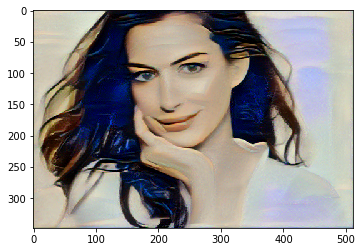

done


In [28]:
print("training started")
print(device)
#train_image()
import matplotlib.pyplot as plt
#下面这句话很关键，不添加的话会不显示图片
%matplotlib inline
img = Image.open("output-2002.png")
plt.imshow(img)
plt.show()
print("done")

总结一下style transfer的任务
网络采取VGG-NET的架构，对输入图片进行求导修改，使其像style文件靠拢，同时对原图不进行过于大的修改(content loss以及style loss)

主要收获有：
具体框架编写的熟悉
jupyter notebook的使用(包括SSH -L的端口转发)
一些细节问题，比如inline
对net有了更直观的认识

